### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 26th at 11.59pm CT
---

## Problem 1

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [1]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    #KAG: Slight edit- changed scales to sigmas. Scales was never defined.
    for scale in sigmas:  
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.manifold import Isomap, TSNE


from scipy import stats
from scipy.stats import norm

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Part 1.1

In [3]:
datadir = '../../../homeworks/hw_data/'
rawdata = np.load(datadir+'hw6_data_1.npy')

features = rawdata[:,0:2]
labels = rawdata[:,2]
#print(features)
#print(labels)

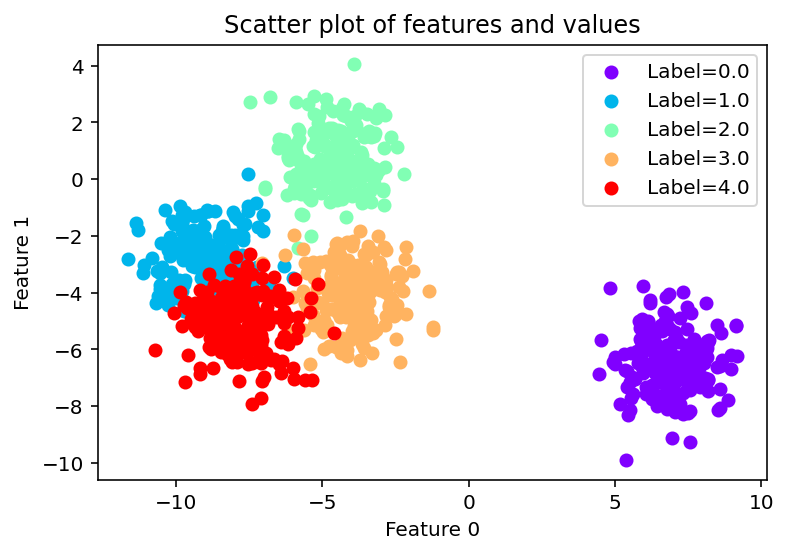

In [4]:
ulabel = np.unique(labels)

colors = plt.cm.rainbow(np.linspace(0,1,len(ulabel)))
for i,l in enumerate(ulabel):
    ind = np.argwhere(labels==l)
    plt.scatter(features[ind,0],features[ind,1],color=colors[i],label=f'Label={l}')
    
plt.legend()
plt.title('Scatter plot of features and values')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

### Part 1.2

In [5]:
print(features.shape) #[Samples, features]

(1000, 2)


In [6]:
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1,1,30)}, cv=5)
grid.fit(features)
h_opt = grid.best_params_['bandwidth']
print(f'Optimal bandwidth for gaussian kernal: {h_opt}')

Optimal bandwidth for gaussian kernal: 0.4724137931034482


/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_53081/2726482383.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(f1_grid, f2_grid))).T


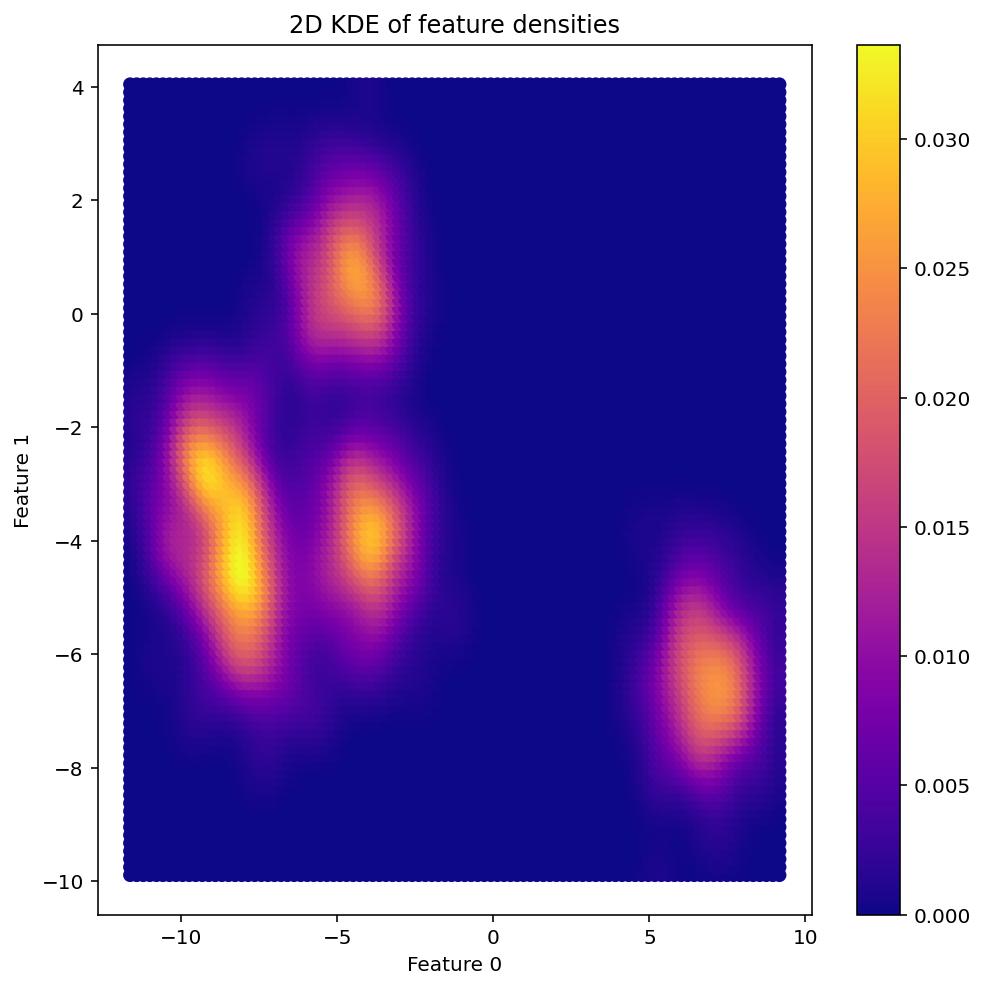

In [7]:
f1_grid = np.linspace(min(features[:,0]),max(features[:,0]),100)
f2_grid = np.linspace(min(features[:,1]),max(features[:,1]),100)

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(features)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(f1_grid, f2_grid))).T
dens = np.exp(kde.score_samples(Xgrid))


plt.figure(figsize=(8,8))
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="plasma")
plt.colorbar()
plt.title('2D KDE of feature densities')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

### Part 1.3

Neighbor value that returns the closest match to KDE: 59


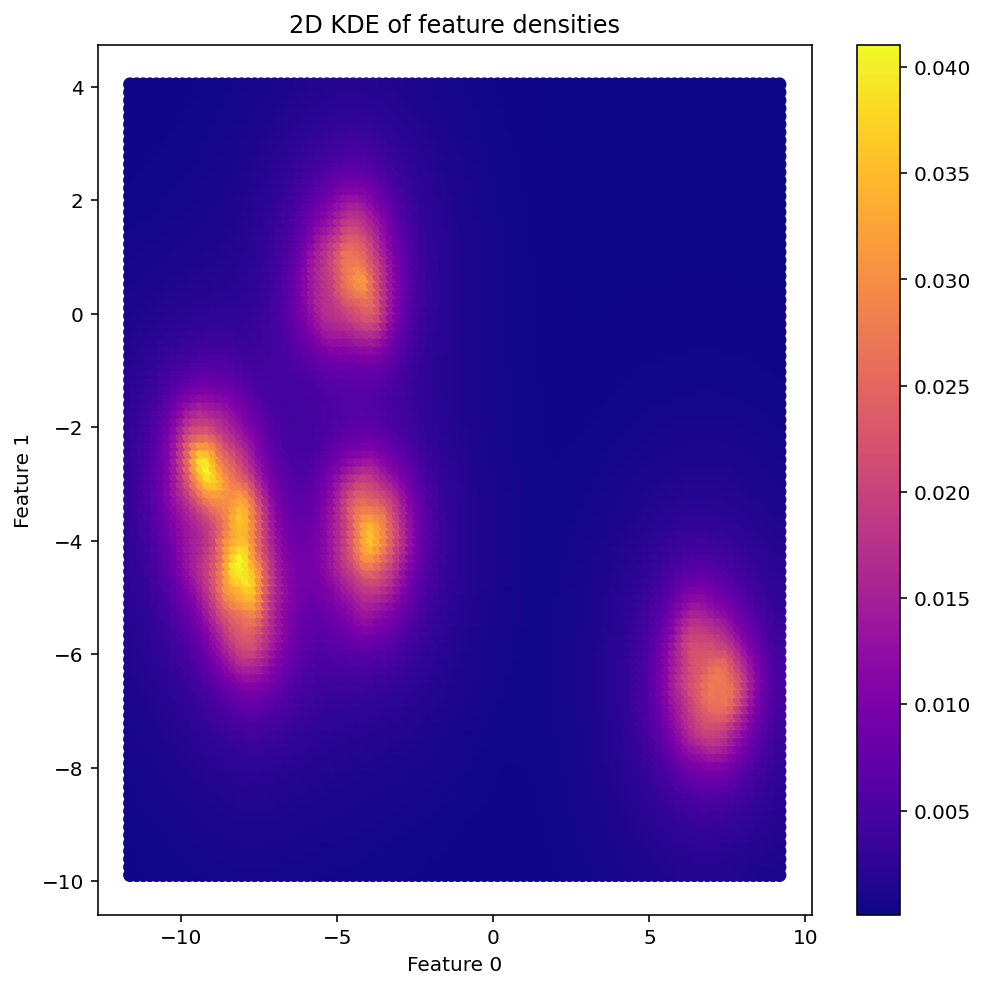

In [8]:
n = 10 #Algortithm gets sketchy with less than 10 neighbors
val = 100 #Used to store xi square. Set to something larger than reasonable

# This method assumes that as you increase n, it gets closer to the other KDE until you start smearing too much
# and the match will get worse. i.e. continuous and xi square with one minimum.
while True:
    nbrs = KNeighborsDensity('bayesian', n_neighbors=n)
    nbrs.fit(features)
    dens_nbrs = nbrs.eval(Xgrid) / len(features)
    dif = np.sum(np.square(dens_nbrs-dens))
    #Calculated xi square is either before or after the lowest point. Break if it is after lowest 
    if dif < val:
        val=dif
        n+=1
    else:
        #Need to recalculate with n-1 since we pass the minimum
        n-=1
        nbrs = KNeighborsDensity('bayesian', n_neighbors=n)
        nbrs.fit(features)
        dens_nbrs = nbrs.eval(Xgrid) / len(features)
        break
        

print(f'Neighbor value that returns the closest match to KDE: {n}')

plt.figure(figsize=(8,8))
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, 
            cmap="plasma")
plt.colorbar()
plt.title('2D KDE of feature densities')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

SRT: Nice work, Kyle!

### Part 1.4

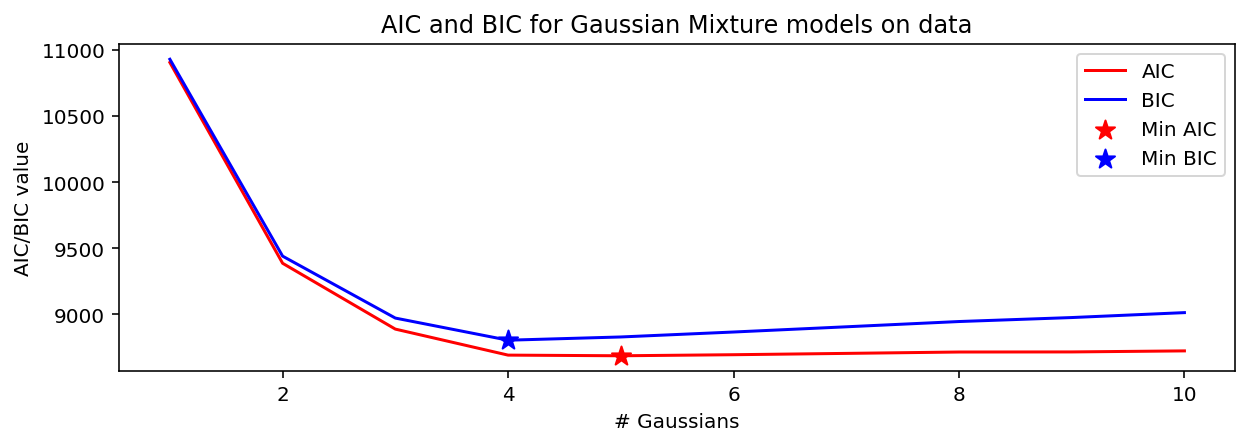

In [9]:
n_gaussians = np.arange(1,11)
models = [GaussianMixture(n).fit(features) for n in n_gaussians]
AIC = [m.aic(features) for m in models]
BIC = [m.bic(features) for m in models]

plt.figure(figsize=(10,3))
plt.plot(n_gaussians,AIC,'r-',label='AIC')
plt.plot(n_gaussians,BIC,'b-',label='BIC')

#Minimum AIC and BIC
n_aic = n_gaussians[np.argmin(AIC)]
n_bic = n_gaussians[np.argmin(BIC)]
plt.scatter(n_aic,AIC[n_aic-1],marker='*',color='r',s=100,label='Min AIC')
plt.scatter(n_bic,BIC[n_bic-1],marker='*',color='b',s=100,label='Min BIC')

plt.title('AIC and BIC for Gaussian Mixture models on data')
plt.ylabel('AIC/BIC value')
plt.xlabel('# Gaussians')
plt.legend()
plt.show()


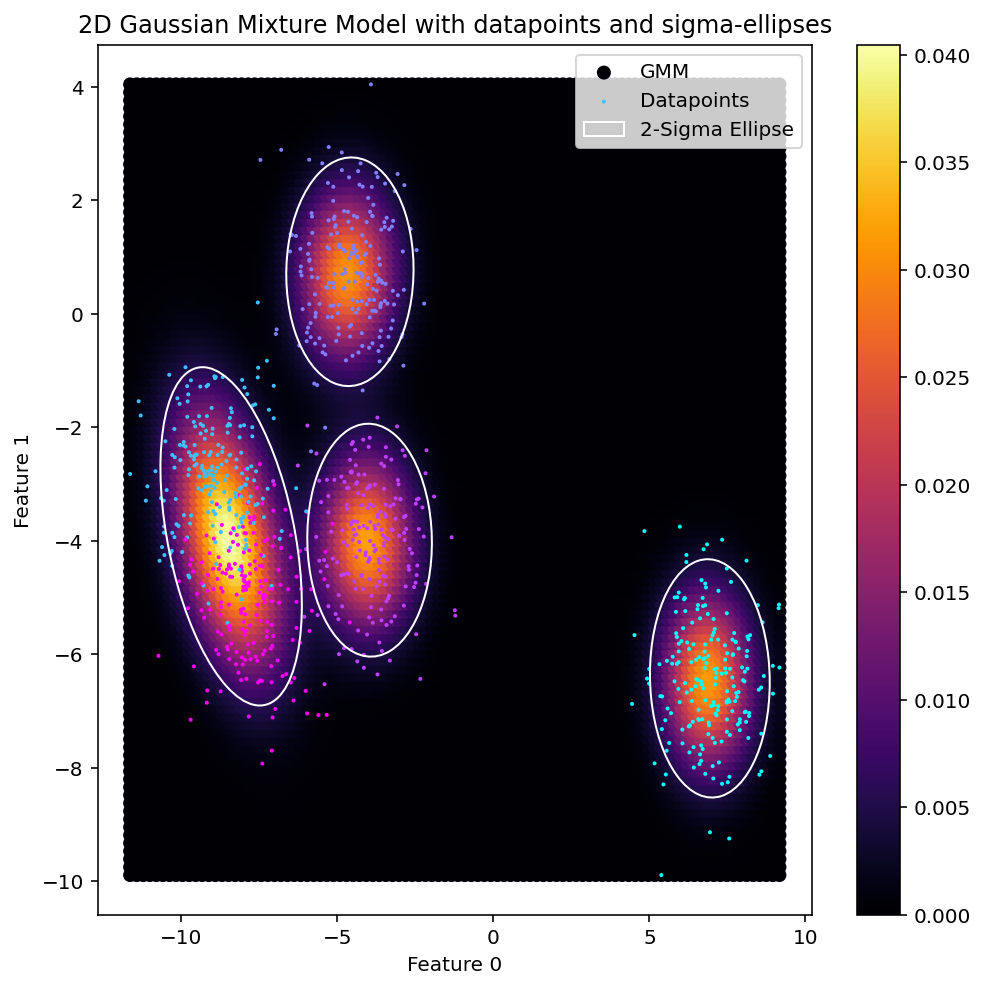

In [10]:
model = GaussianMixture(n_bic).fit(features)
dens_gmm = np.exp(model.score_samples(Xgrid))

#new plot that shows the data set, the GMM component mean locations, and the  2 -sigma GMM component ellipses.
plt.figure(figsize=(8,8))

#Plot the GMM
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_gmm, 
            cmap="inferno")
plt.colorbar()

#Plot datapoints
plt.scatter(features[:,0],features[:,1],c=labels,s=1,cmap='cool')

#Plot 2-sigma  ellipses
for mu,c in zip(model.means_,model.covariances_):
    draw_ellipse(mu=mu,C=c,sigmas=[2],edgecolor='w',facecolor='none')

plt.title('2D Gaussian Mixture Model with datapoints and sigma-ellipses')
plt.legend(['GMM','Datapoints','2-Sigma Ellipse'])
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

SRT: Great!

### Part 1.5

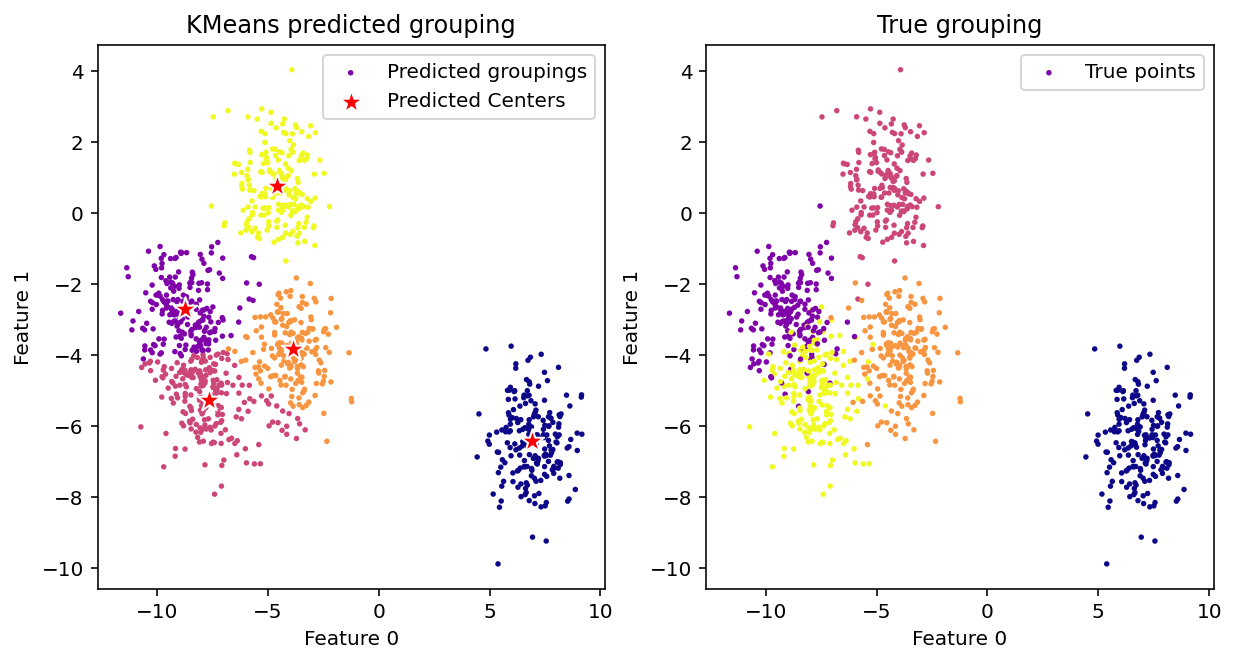

In [11]:
scaler = preprocessing.StandardScaler()

clf = KMeans(n_clusters=5)
clf.fit(scaler.fit_transform(features))
klabels = clf.predict(scaler.fit_transform(features))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(features[:,0],features[:,1],c=klabels,cmap='plasma',s=3)
c_centers = scaler.inverse_transform(clf.cluster_centers_)
plt.scatter(c_centers[:,0],c_centers[:,1],c='r',marker='*',s=150,edgecolors='w')
plt.title('KMeans predicted grouping')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend(['Predicted groupings','Predicted Centers'])

plt.subplot(1,2,2)
plt.scatter(features[:,0],features[:,1],c=labels,cmap='plasma',s=3)
plt.title('True grouping')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend(['True points'])

plt.show()

SRT: Awesome!

---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.

In [12]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

### Part 2.2

In [13]:
pca = PCA(n_components=2)
pca.fit(X)
print(f'The total explained variance in the two PCA parameters = {np.sum(pca.explained_variance_ratio_)*100}%')

The total explained variance in the two PCA parameters = 78.33146203950645%


### Part 2.3

In [14]:
typeInts = data['type']
print(np.unique(typeInts))
help(fetch_imaging_sample)

"""
From the SQL script below, it selects for type 3 and 6, which agrees with what I have. It also says that its from 
SDSS, so you can look at 'https://www.sdss.org/dr12/algorithms/classify/' which tells us that 
the classification is due to either resolved sources or unresolved ones, which means:

type 3 -> Galaxy
type 6 -> Star
""";

[3 6]
Help on function fetch_imaging_sample in module astroML.datasets.imaging_sample:

fetch_imaging_sample(data_home=None, download_if_missing=True)
    Loader for SDSS Imaging sample data
    
    Parameters
    ----------
    data_home : optional, default=None
        Specify another download and cache folder for the datasets. By default
        all astroML data is stored in '~/astroML_data'.
    
    download_if_missing : optional, default=True
        If False, raise a IOError if the data is not locally available
        instead of trying to download the data from the source site.
    
    Returns
    -------
    data : recarray, shape = (330753,)
        record array containing imaging data
    
    Examples
    --------
    >>> from astroML.datasets import fetch_imaging_sample
    >>> data = fetch_imaging_sample()  # doctest: +IGNORE_OUTPUT +REMOTE_DATA
    >>> # number of objects in dataset
    >>> data.shape  # doctest: +REMOTE_DATA
    (330753,)
    >>> # names of the first 

SRT: Great!

### Part 2.4

In [15]:
#Get random integers
randInts = np.random.randint(0,len(data),size=5100)
#Check if there are at least 5000 unique points
#print(len(np.unique(randInts)))

#Get first 5000 unique points
randInts = np.unique(randInts)[:5000]

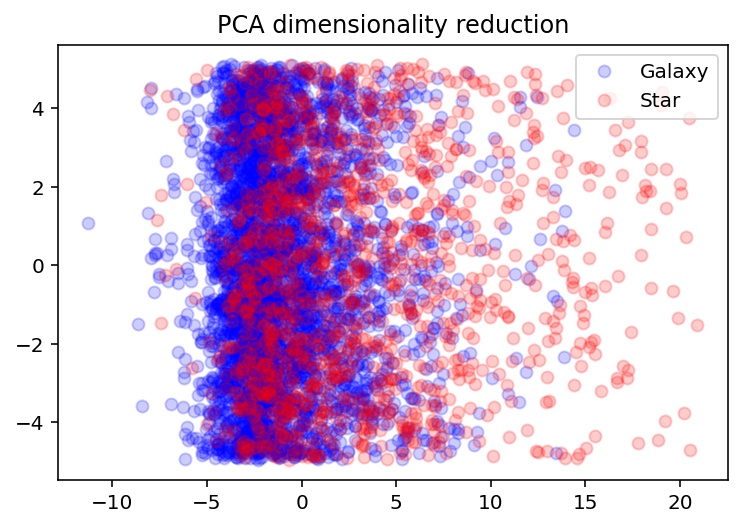

In [16]:
galI = np.argwhere(data['type'][randInts]==3)
starI = np.argwhere(data['type'][randInts]==6)

pts = pca.transform(X[randInts])
plt.plot(pts[galI,0],pts[galI,1],'ob',label='Galaxy',alpha=0.2)
plt.plot(pts[starI,0],pts[starI,1],'or',label='Star',alpha=0.2)
plt.legend()
plt.title('PCA dimensionality reduction')
plt.show()

### Part 2.5

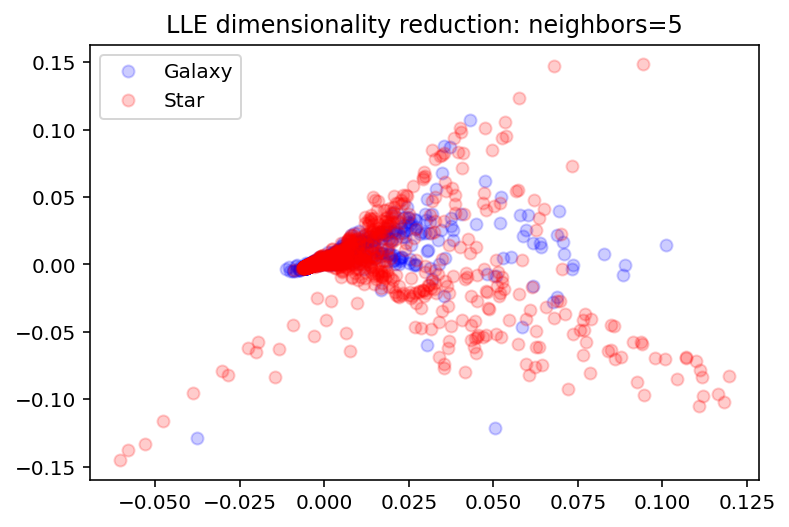

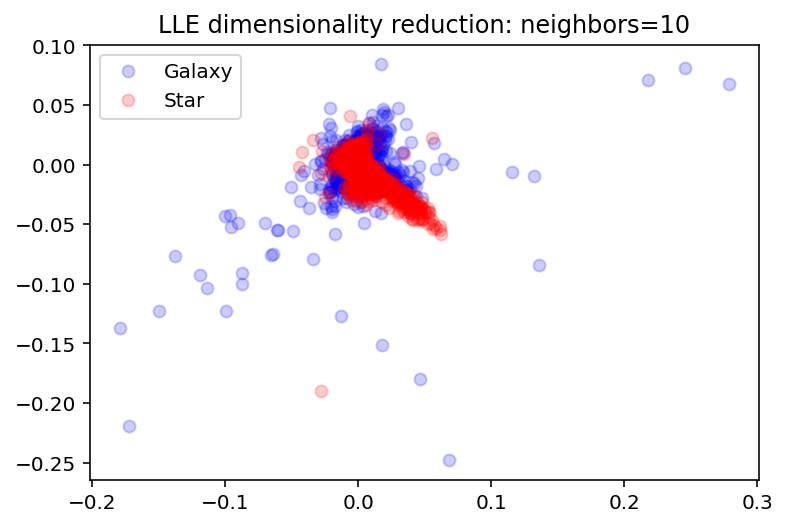

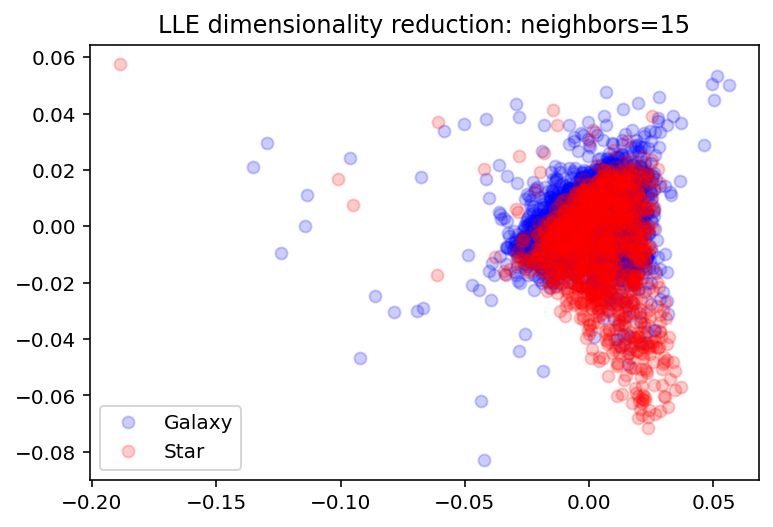

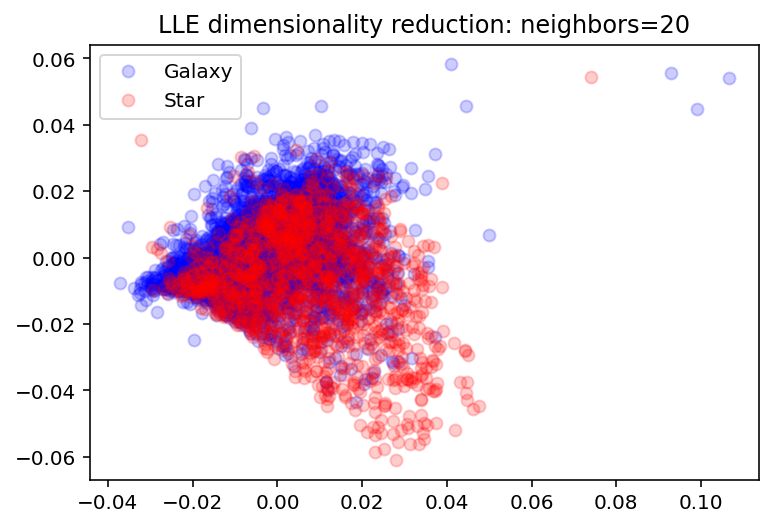

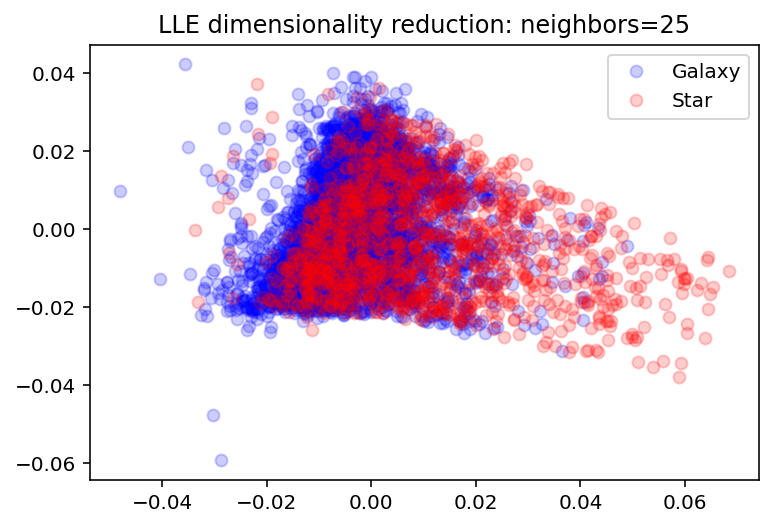

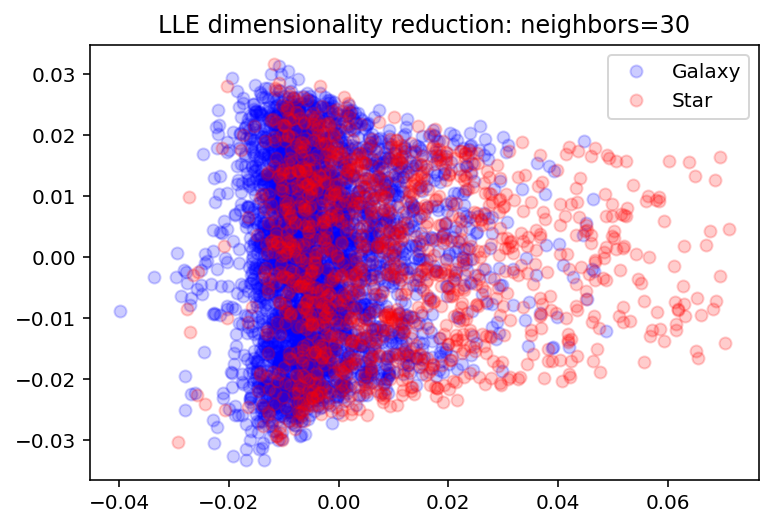

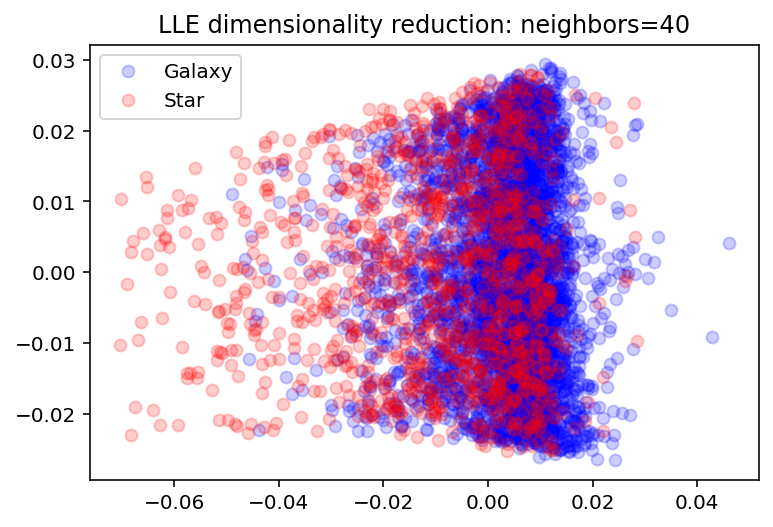

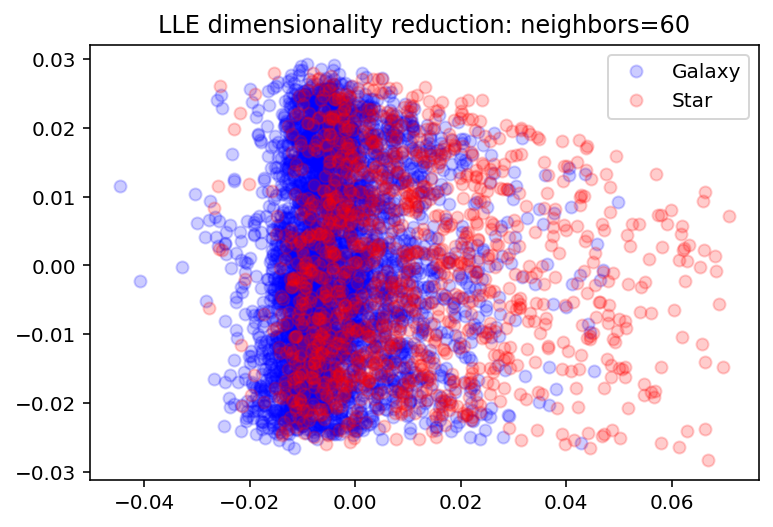

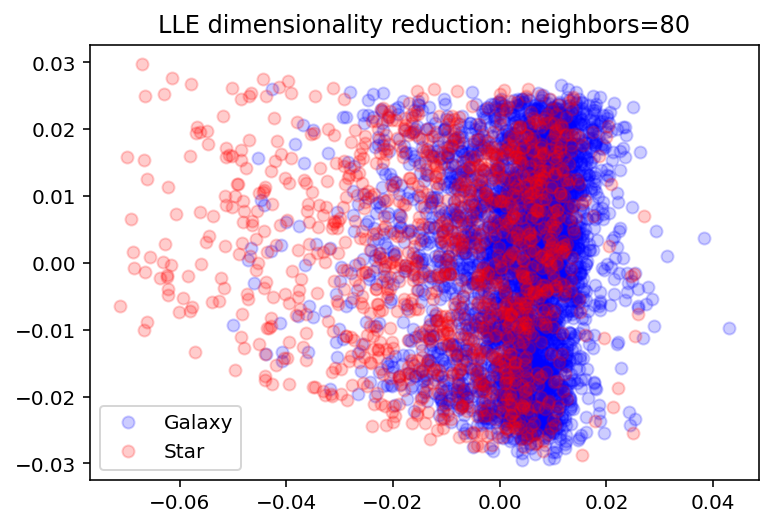

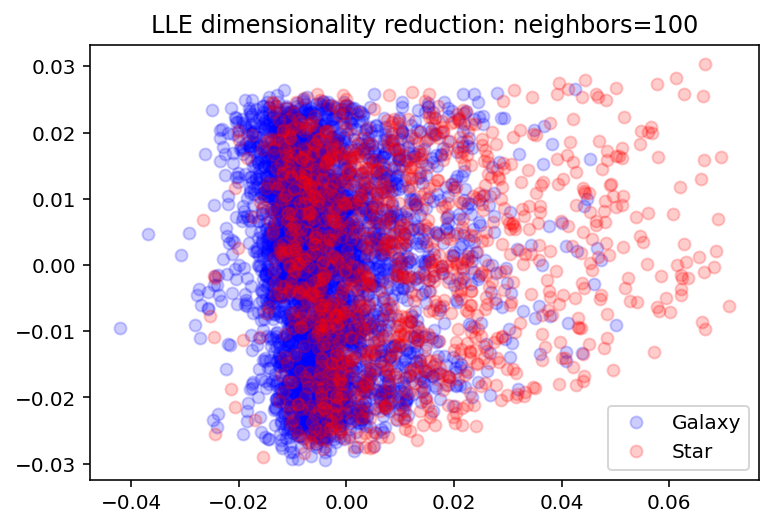

In [17]:
"""
LLE starts to look more like PCA with many neighbors (which makes sense), however, this change
towards more PCA results happens at low-ish neighbor numbers
"""

for n in [5,10,15,20,25,30,40,60,80,100]:

    lle = LLE(n_neighbors=n,n_components=2)
    lle.fit(X[randInts])

    pts = lle.transform(X[randInts])
    plt.plot(pts[galI,0],pts[galI,1],'ob',label='Galaxy',alpha=0.2)
    plt.plot(pts[starI,0],pts[starI,1],'or',label='Star',alpha=0.2)
    plt.legend()
    plt.title(f'LLE dimensionality reduction: neighbors={n}')
    plt.show()

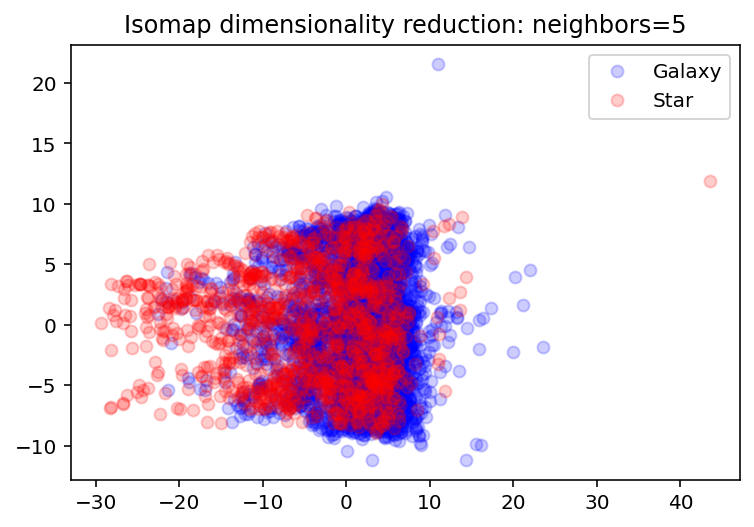

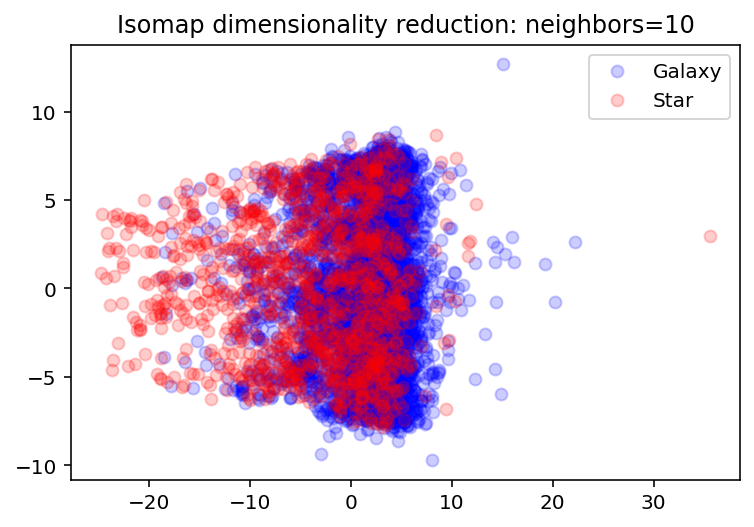

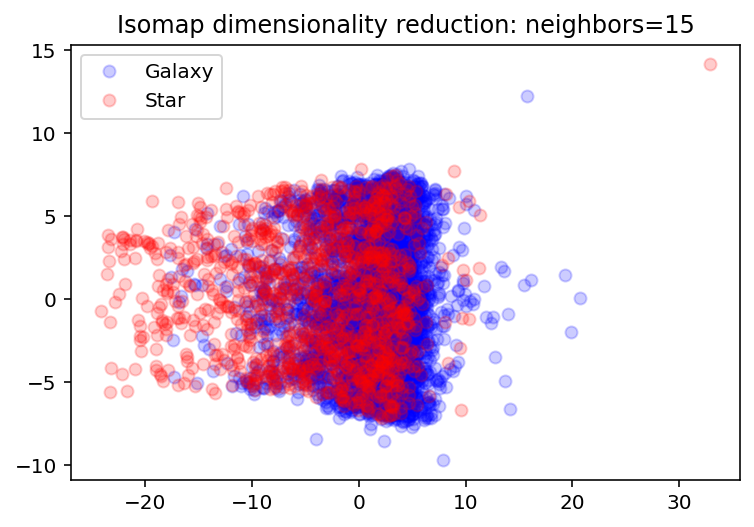

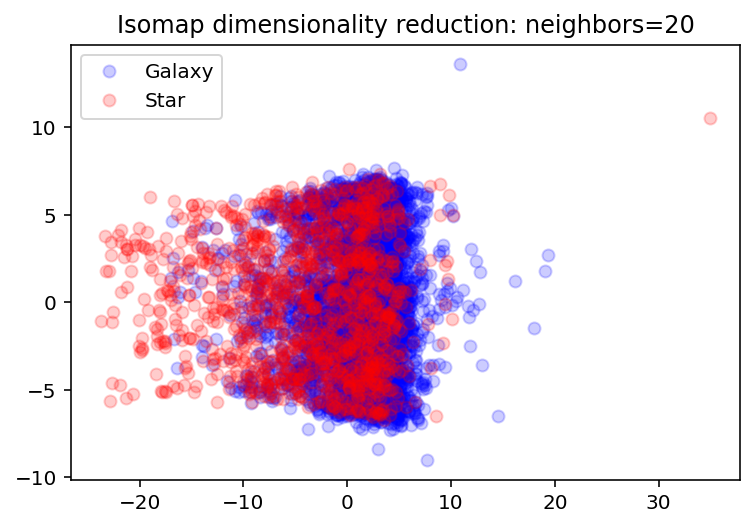

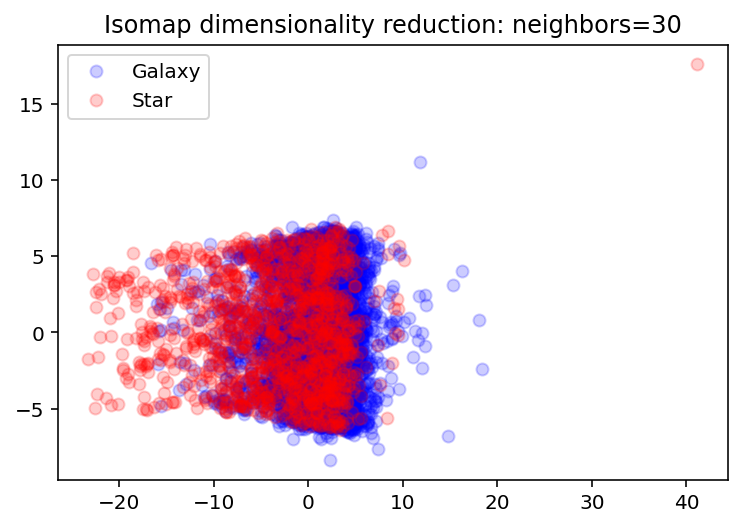

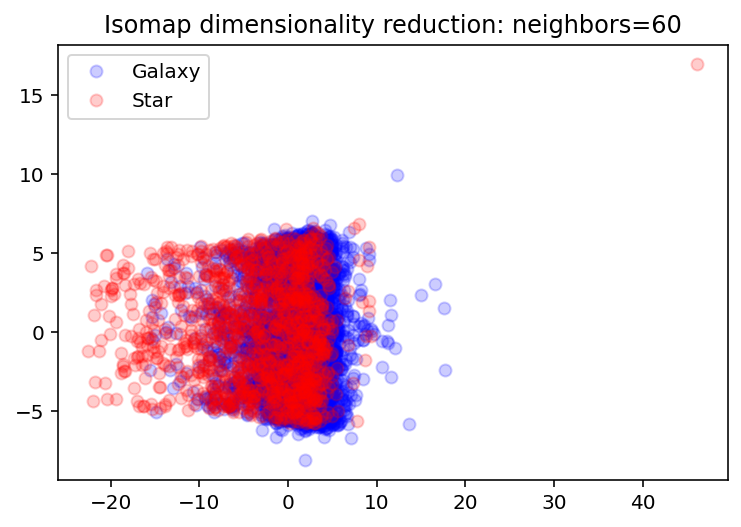

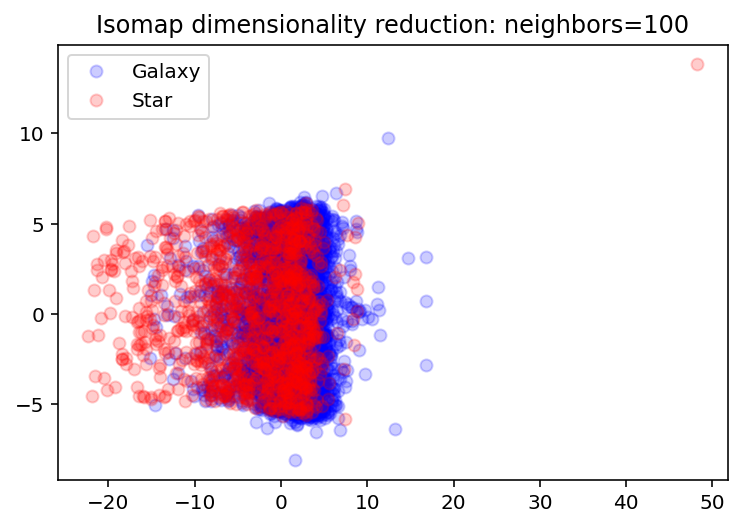

In [18]:
for n in [5,10,15,20,30,60,100]:

    iso = Isomap(n_neighbors=n,n_components=2)
    iso.fit(X[randInts])

    pts = iso.transform(X[randInts])
    plt.plot(pts[galI,0],pts[galI,1],'ob',label='Galaxy',alpha=0.2)
    plt.plot(pts[starI,0],pts[starI,1],'or',label='Star',alpha=0.2)
    plt.legend()
    plt.title(f'Isomap dimensionality reduction: neighbors={n}')
    plt.show()

/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


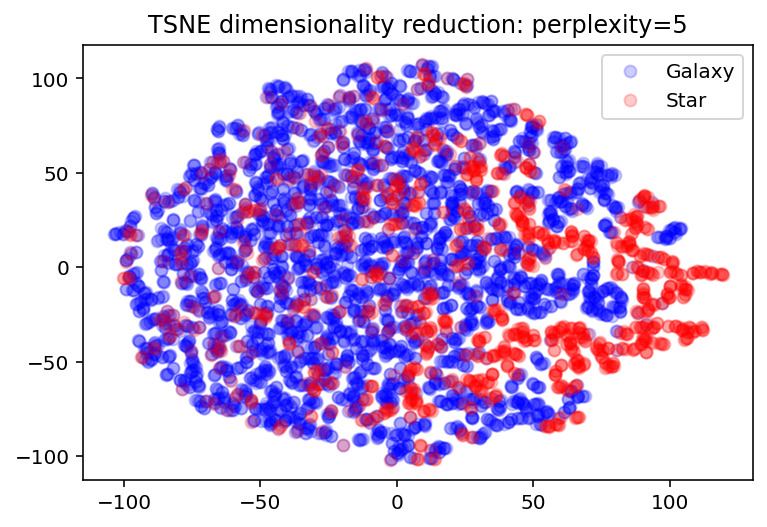

/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


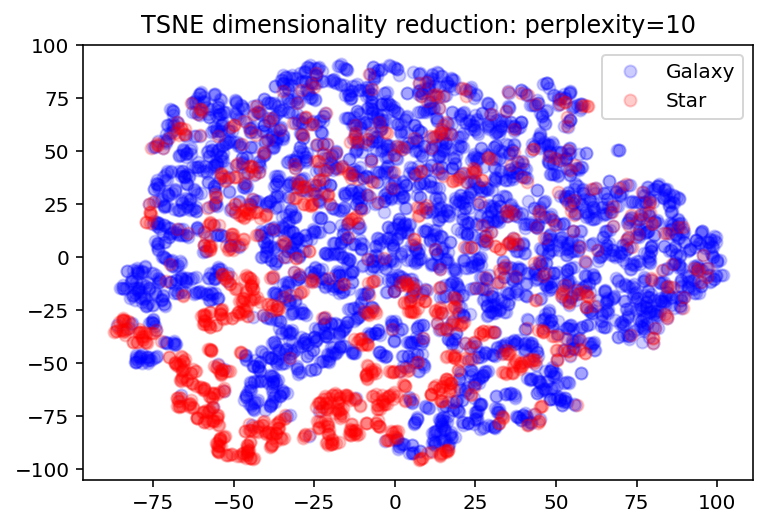

/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


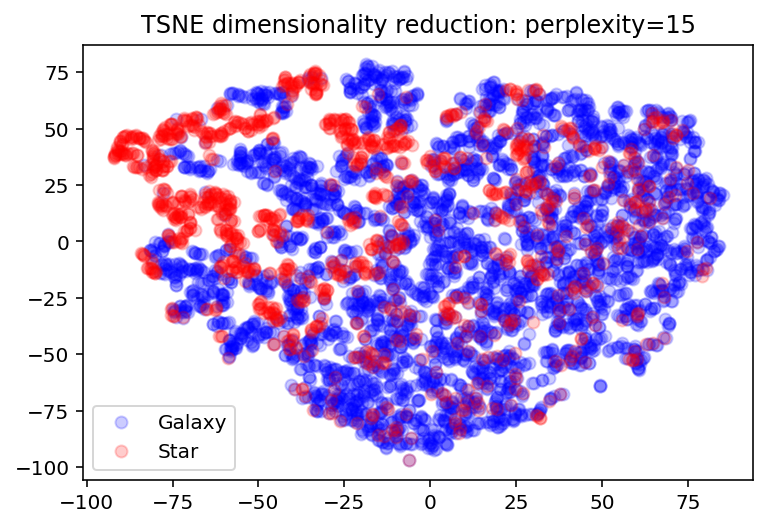

/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


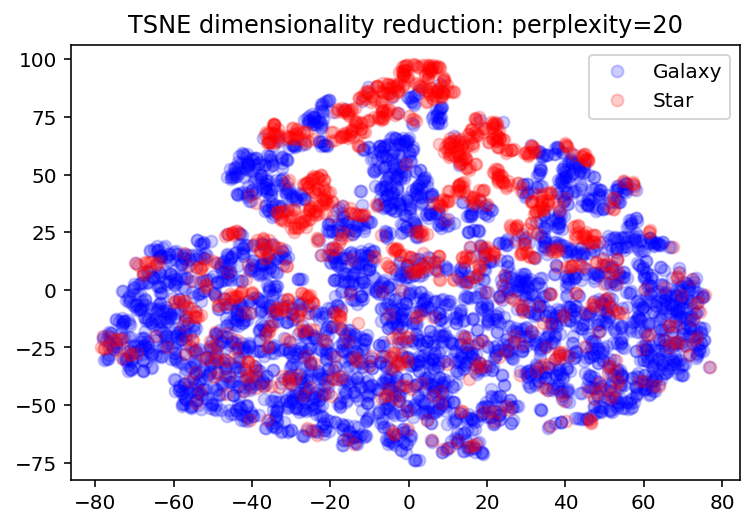

/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


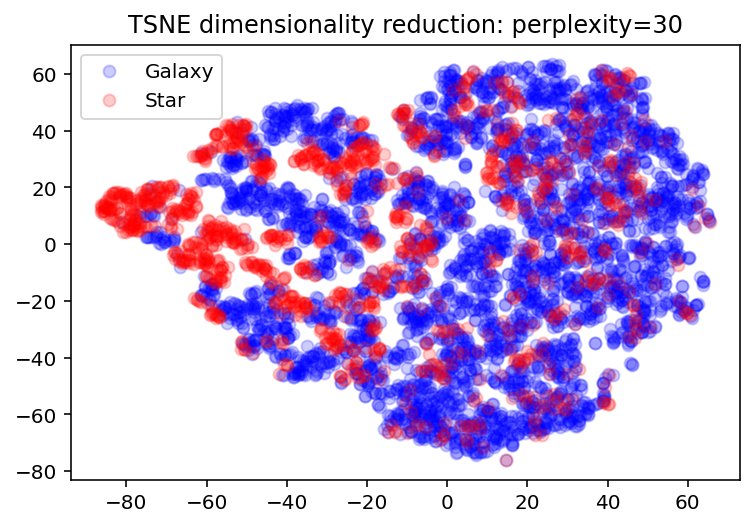

/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


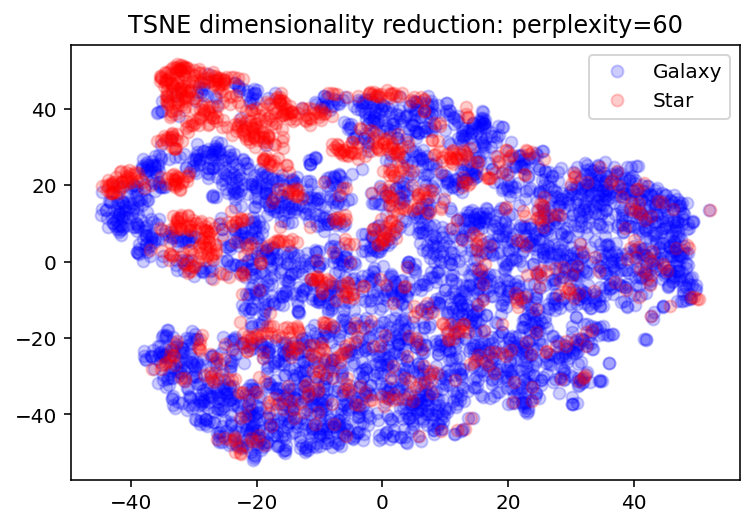

/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gersbaka/opt/anaconda3/envs/astro8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


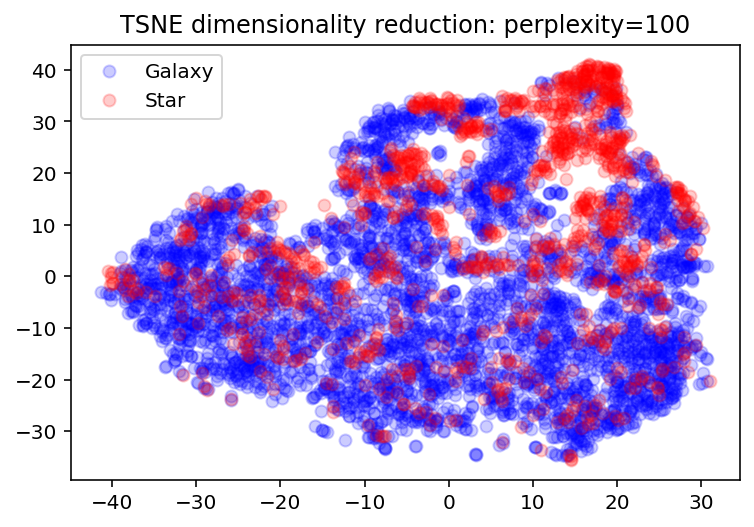

In [19]:
for n in [5,10,15,20,30,60,100]:

    tsne = TSNE(n_components=2,perplexity=n)

    pts = tsne.fit_transform(X[randInts])
    plt.plot(pts[galI,0],pts[galI,1],'ob',label='Galaxy',alpha=0.2)
    plt.plot(pts[starI,0],pts[starI,1],'or',label='Star',alpha=0.2)
    plt.legend()
    plt.title(f'TSNE dimensionality reduction: perplexity={n}')
    plt.show()

### Discussion

#### NOTE: I ran these with a different random subset of stars/galaxies. My plots below here are copy/pasted from a different run. The general thoughts are the same, but the locations will be slightly different. Sorry!

As is shown in the PCA plots, these objects (stars and galaxies) both share significant similarities between them. Despite this PCA was able to show that there is some minor differences between these object types. Shown below is the plot that PCA created. 

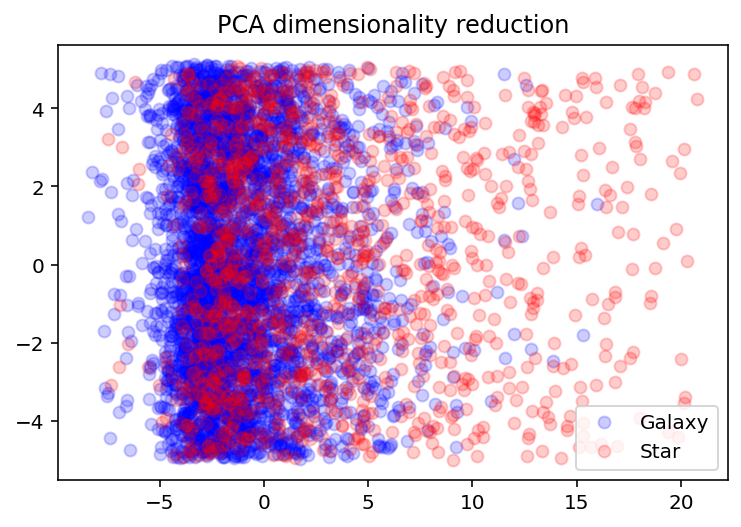

This plot shows that while stars and galaxies occupy the same dimensionality space, there does seem to be slightly more spread in these parameters in stars than in galaxies. I suspect its due to some averaging of spectra (central limit theorem maybe?)

Similar situations happened with the other 3 algorithms.

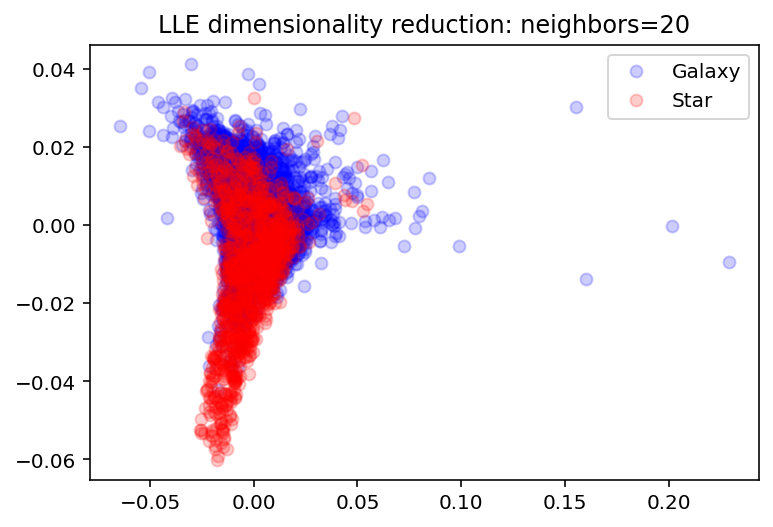

LLE with around 20 nearest neighbors shows some promise, but even LLE struggled to find much of anything different. There is some separation in the bottom left and top right, but there is still far too much overlap for anything very informative.

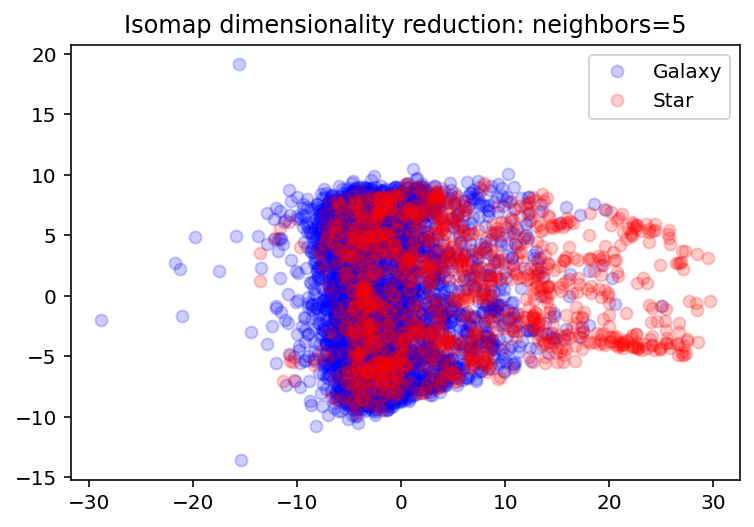

Isomap is the most surprising as the number of neighbors used in this algorithm hardly changed their separations, or even their shape. Practically everything remained the same, and you'd have to get down to more significant statistics that the 'by-eye' method.

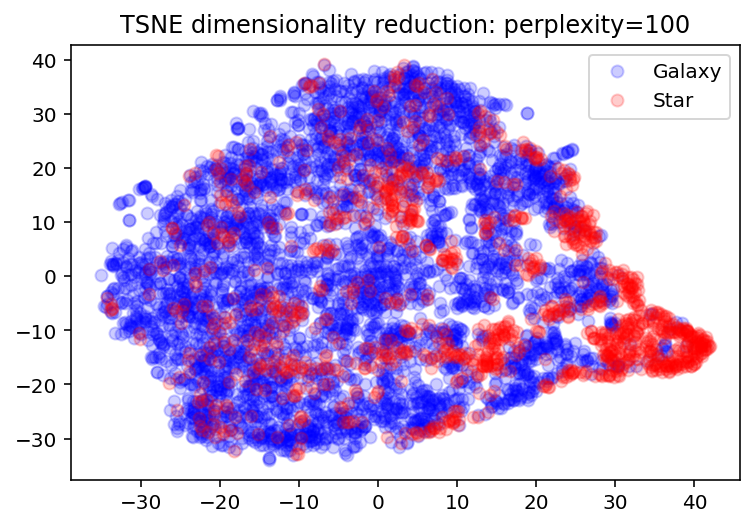

Finally, with TSNE, there is some marginal improvements, especially with higher perplexity. There is some separation happening in the bottom right and left sides of this plot. While minor, it does appear that there are measurable differences, at least between a few combined parameters. 

This data shows that, while these techniques are powerful, they aren't perfect. They can't separate objects completely every time, and this dataset is not suitable for these techniques. My suggestions would be to attempt some supervized learning techniques, or machine learning, as knowing the results might help separate the data better.


SRT: Very nice work, Kyle.